In [1]:
# !pip install modin[all]
# !pip install scikit-learn-extra
# !pip install ray

In [2]:
#Importing stuff
import sys
import modin.pandas as pd
# import modin.config as cfg
# from distributed import Client
from datetime import datetime

# import pandas as pd
from sklearn.metrics import silhouette_score

from Clustering.KMeansFamily.kmeansfamily import kmeans
from DataPreProcessing.importance import reduce_dimensionality
from OutliersDetection.CBOD import CBOD
from OutliersDetection.LDOF import top_n_LDOF
from Tuning.MATR import MATR

from Utils.Visualization.visualization import visualize_cluster
from Utils.distances import euclidean_distance

import ray

ray.shutdown()
ray.init()

2022-09-20 09:14:30,054	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:45639', 'raylet_socket_name': 'tcp://127.0.0.1:33464', 'webui_url': '127.0.0.1:8265', 'session_dir': 'C:\\Users\\nsimo\\AppData\\Local\\Temp\\ray\\session_2022-09-20_09-14-27_091156_11036', 'metrics_export_port': 53467, 'gcs_address': '127.0.0.1:43700', 'address': '127.0.0.1:43700', 'node_id': '0719200bdb4b7173b6e68511926470e2369ce76a0b70de232929b938'})

In [3]:
#Importing Data
test_data = pd.read_csv("Data/sessions_cleaned.csv", sep=",", skipinitialspace=True, skipfooter=3,
                        engine='python')

n_dims = pd.Series([i for i in range(8,15)], index=[str(i) for i in range(8,15)])

pca_data = n_dims.apply(lambda n_dim: (reduce_dimensionality(data=test_data, n_final_features=n_dim), n_dim))

In [4]:
# Settings
EXP_NUM = 3

settings_KMEANS = {'n_init': 10,
                   'max_iter': 500,
                   'verbose': 0,
                   'algorithm': 'auto',
                   'distance': euclidean_distance}

settings_LDOF = {
    'n': 10,
    'k': 10
}

settings_CBOD = {
    'epsilon': 0.005
}

param = [{'n_clusters': i} for i in range(11, 17)]


(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
(_apply_func pid=15064) FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 's

CPU times: total: 8.92 s
Wall time: 40 s


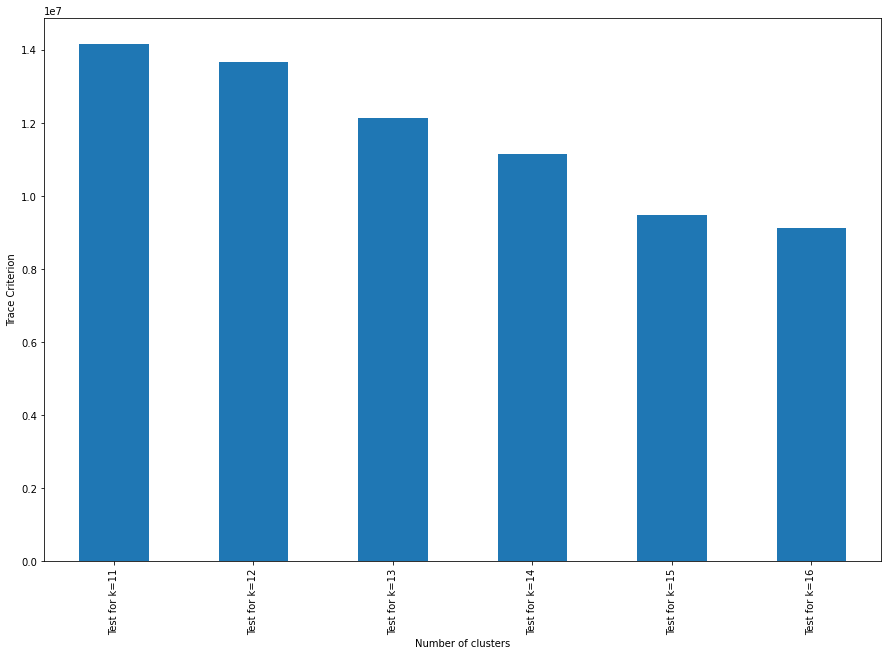

In [5]:
%%time
import numpy as np
timestamp1 = datetime.now()

aux1 = pca_data.apply(lambda data: MATR(A=kmeans, D=data[0], hyperpar=param, settings=settings_KMEANS, verbose=1, path="Data/Results/Experiments/", name=f"[{EXP_NUM}]Experiment - PCA_{data[1]}_dim-KMeans"))
aux1.name = 'MATR'
aux2 = pca_data.apply(lambda data: data[1])
aux2.name = 'PCA_dim'
aux3 = aux1.apply(lambda data: silhouette_score(X=data[list(set(data.columns) - {'cluster'})], labels=data['cluster']))
aux3.name = 'silhouette'

# result = pd.concat([aux1, aux2, aux3], axis=1, names=["MATR","PCA_dim","silhouette"])
# print(f"aux1:\n{aux1.shape}")
# aux1.info()
# print(f"\naux2:\n{aux2.shape}")
# aux2.info()
# print(f"\naux3:\n{aux3.shape}")
# aux3.info()

result = pd.concat([aux2,aux3], axis=1, names=["PCA_dim","silhouette"])

timestamp1 = datetime.now() - timestamp1

CPU times: total: 188 ms
Wall time: 210 ms


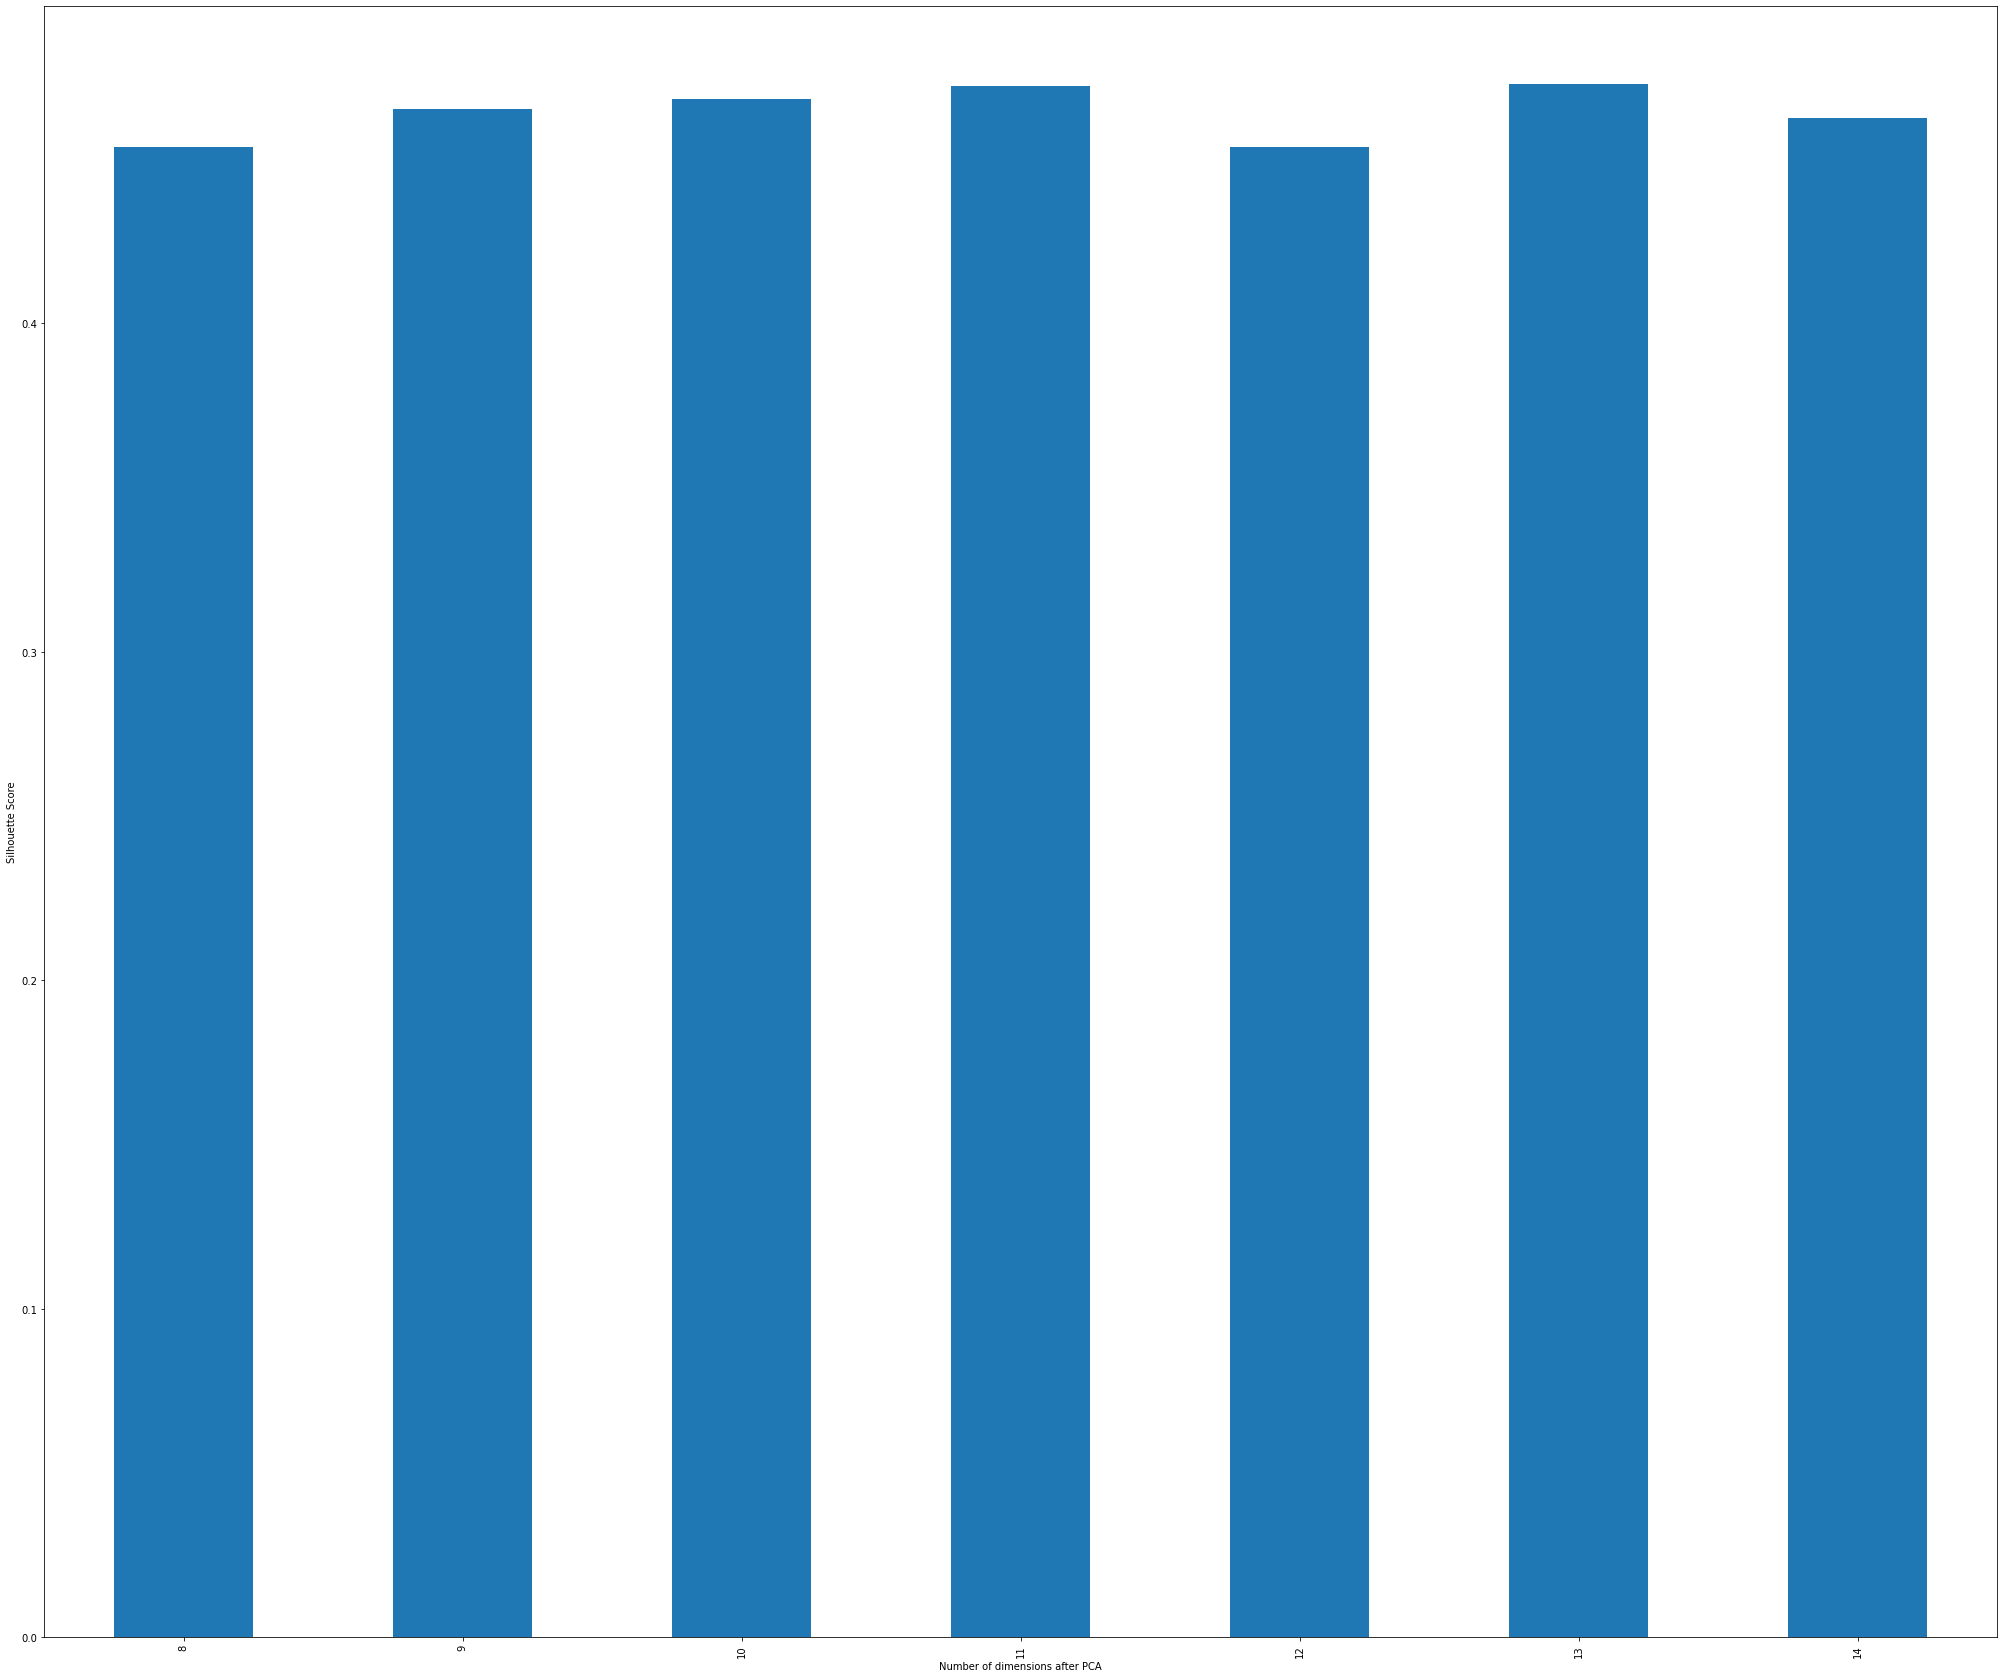

In [6]:
%%time
# Printing results
timestamp2 = datetime.now()
result["silhouette"].plot(kind="bar", xlabel= "Number of dimensions after PCA", ylabel="Silhouette Score", figsize=(35, 30)).get_figure().savefig(
    f'Data/Results/Experiments/PCA-KMeans_sil_score{EXP_NUM}.png')
timestamp2 = datetime.now() - timestamp2

CPU times: total: 12.6 s
Wall time: 12.8 s


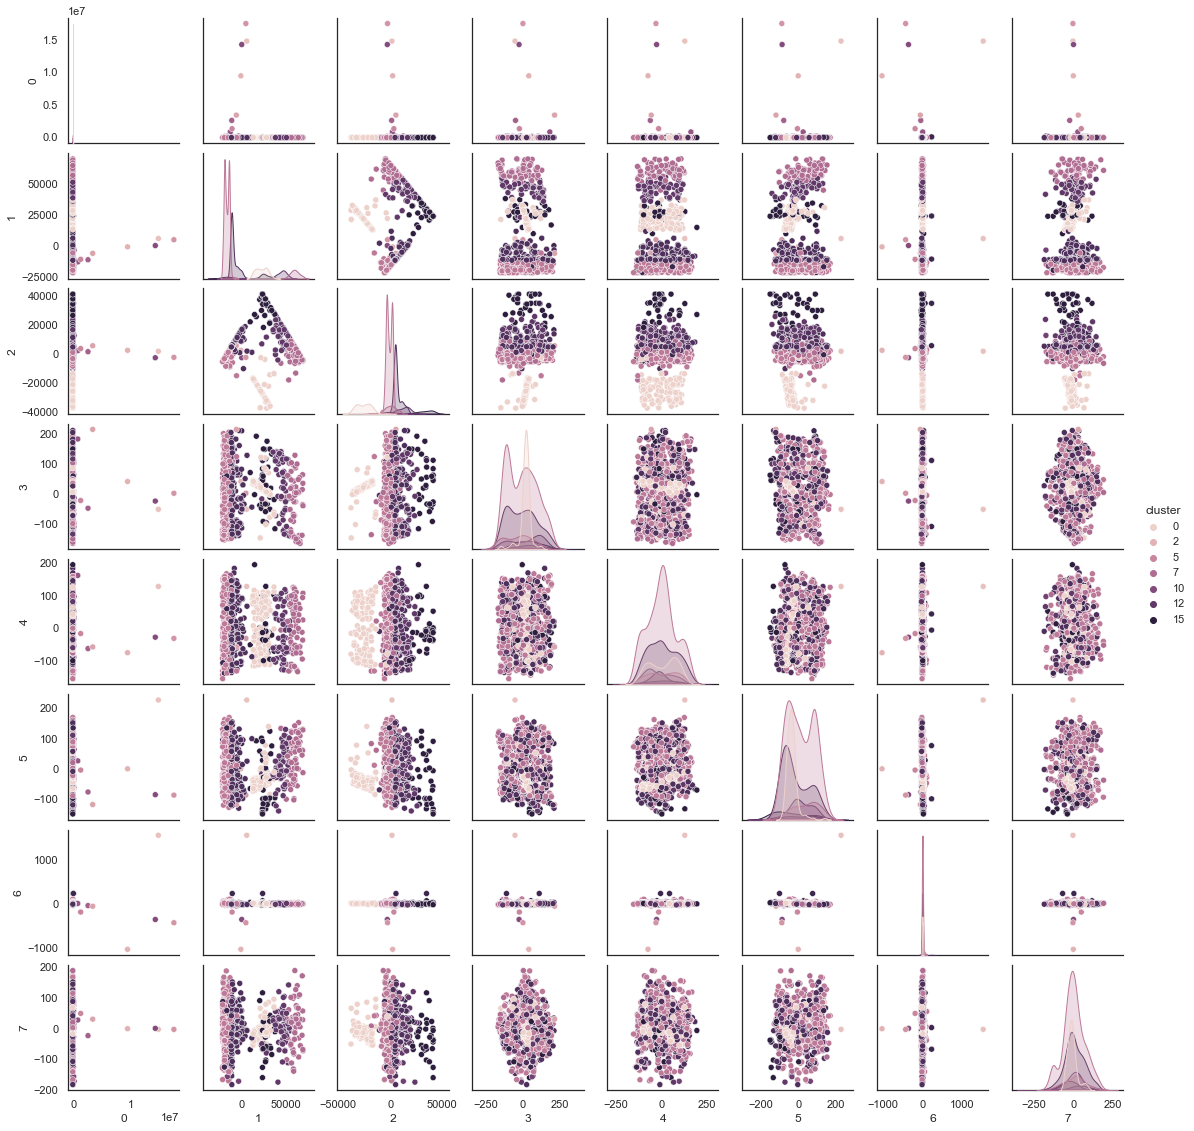

In [7]:
%%time
# Printing the clusters
timestamp3 = datetime.now()
    
aux1.apply(lambda res: visualize_cluster(data=res, 
                         i=EXP_NUM,
                         cluster_or_outliers='cluster',
                         additional=f"PCA_{len(res.columns) - 1}_dim-KMEANS_{res['cluster'].max() + 1}",
                         path="Data/Results/Experiments/"))

timestamp3 = datetime.now() - timestamp3

In [8]:
%%time
# Outlier detection JUST 8 DIMENSIONS
timestamp4 = datetime.now()  

res = aux1['8']

det_ldof = top_n_LDOF(data=res, distance=euclidean_distance, n=settings_LDOF['n'], k=settings_LDOF['k']) 

det_ldof.info()
    
timestamp4 = datetime.now() - timestamp4

KeyboardInterrupt: 

In [9]:
%%time
timestamp5 = datetime.now() 
det_cbod = CBOD(data=res, k=res['cluster'].max() + 1, epsilon=settings_CBOD['epsilon'])

det_cbod.info()
timestamp5 = datetime.now() - timestamp5

KeyError: 'cluster1'

In [10]:
%%time
visualize_cluster(data=det_ldof[list(set(det_ldof.index) - {'cluster'} - {'LDOF'})], 
                 i=EXP_NUM,
                 cluster_or_outliers='outlier',
                 additional=f"[LDOF]PCA_{len(det_ldof.columns) - 2}_dim-KMEANS_{det_ldof['cluster'].max() + 1}",
                 path="Data/Results/Experiments/")

NameError: name 'det_ldof' is not defined

In [11]:
%%time
visualize_cluster(data=det_cbod[list(set(det_cbod.index) - {'cluster'})], 
                 i=EXP_NUM,
                 cluster_or_outliers='outlier',
                 additional=f"[CBOD]PCA_{len(det_cbod.columns) - 1}_dim-KMEANS_{det_cbod['cluster'].max() + 1}",
                 path="Data/Results/Experiments/")

NameError: name 'det_cbod' is not defined

In [12]:
%%time
res_ldof = test_data.loc[det_ldof.index, :]

res_cbod = test_data.loc[det_cbod.index, :]

NameError: name 'det_ldof' is not defined

In [13]:
%%time
# Printing log file
# Saving the reference of the standard output
original_stdout = sys.stdout
with open(f'Data/Results/Experiments/[Experiment PCA-KMeans-MATR]_main_log_{EXP_NUM}.txt', 'w') as f:
    sys.stdout = f
    # Reset the standard output
    print(f"PCA number of dimensions parameter:\t{n_dims}")
    print(f"KMeans number of cluster candidates:\t{range(10, 16)}")
    print(f"KMeans settings:\t{settings_KMEANS}")
    print(f"LDOF settings:\t{settings_LDOF}")
    print(f"CBOD settings:\t{settings_CBOD}")
    print(f"Time elapsed for MATR computation (all of the datasets):\t{timestamp1}")
    print(f"Time elapsed for Outlier Detection (LDOF):\t{timestamp4}")
    print(f"Time elapsed for Outlier Detection (CBOD):\t{timestamp5}")
    print(f"Time elapsed for Silhouette Scores plotting:\t{timestamp2}")
    print(f"Time elapsed for Clusters plotting:\t{timestamp3}")
sys.stdout = original_stdout

CPU times: total: 46.9 ms
Wall time: 114 ms


In [ ]:
original_stdout = sys.stdout
i = 0
for res in aux1:
    with open(f'Data/Results/Experiments/[Experiment PCA-KMeans-MATR]_exp{i + 1}_log_{EXP_NUM}.txt', 'w') as f:
        print(f"\nResults:\n{'-' * 15}")         
        index = result.index(res)
        print(f"\n{'=' * 5}TEST No. {i}{'=' * 5}")
        print(f"\tDataset dimensions:\t{len(res.columns) - 1}")
        print(f"\tNumber of clusters:\t{res['cluster'].max() + 1}")
        print(f"\tSilhouette Score:\t{result['silhouette'].iloc[index]}")
        print(f"\tOutliers detected:\n\t{'^' * 3}\n")
        print(f"\t[LDOF]")
        with pd.option_context('expand_frame_repr', False):
            print(det_ldof[index].head(n=det_ldof[index].shape[0]))
        print(f"\t[CBOD]")
        print(f"Number of outliers:\t{det_cbod[index].shape[0]}\tNumber of instances:\t{res[0].shape[0]}")
        det_cbod[index].head(n=det_cbod[index].shape[0])
        print(f"\n\t{'^' * 3}")
        print(f"{'=' * 15}\n")
        i += 1
        print(f"\n{'-' * 15}\n")

sys.stdout = original_stdout

In [ ]:
ray.shutdown()

In [ ]:
%%time

det_ldof.apply(lambda res: visualize_cluster(data=res[list(set(res.index) - {'cluster'} - {'LDOF'})], 
                         i=EXP_NUM,
                         cluster_or_outliers='outlier',
                         additional=f"[LDOF]PCA_{len(res.columns) - 2}_dim-KMEANS_{res['cluster'].max() + 1}",
                         path="Data/Results/Experiments/"))

det_cbod.apply(lambda res: visualize_cluster(data=res[list(set(res.index) - {'cluster'})], 
                         i=EXP_NUM,
                         cluster_or_outliers='outlier',
                         additional=f"[CBOD]PCA_{len(res.columns) - 1}_dim-KMEANS_{res['cluster'].max() + 1}",
                         path="Data/Results/Experiments/"))

In [ ]:
%%time
# Outlier detection
timestamp4 = datetime.now()  

det_ldof = aux1.apply(lambda res: top_n_LDOF(data=res, distance=euclidean_distance, n=settings_LDOF['n'], k=settings_LDOF['k']))    
    
det_cbod = aux1.apply(lambda res: CBOD(data=res, k=res['cluster'].max() + 1, epsilon=settings_CBOD['epsilon']))

timestamp4 = datetime.now() - timestamp4